In [5]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, precision_recall_curve, average_precision_score, roc_auc_score

snr_list = ['6_dB', '-6_dB', '0_dB']

def read_csv_files(pattern='anomaly_score_*.csv', test=False):
    if test:
        return glob.glob(os.path.join('test', pattern))
    else:
        return glob.glob(os.path.join(pattern))
    
# 파일 이름에서 레이블을 결정하는 함수
def get_label(filename):
    if 'anomaly' in filename:
        return 1
    else:
        return 0

def get_labels_and_scores(csv_files):
    actual_labels = []
    anomaly_scores = []
    for file in csv_files:
        df = pd.read_csv(file, header=None)
        df.columns = ['filename', 'anomaly_score']
        df['label'] = df['filename'].apply(get_label)
        actual_labels.extend(df['label'].tolist())
        anomaly_scores.extend(df['anomaly_score'].tolist())
    return pd.Series(actual_labels), pd.Series(anomaly_scores)



In [6]:
def get_labels_and_scores_n(csv_files):
    actual_labels = []
    anomaly_scores = []
    normal_anomaly_scores = []
    for file in csv_files:
        df = pd.read_csv(file, header=None)
        df.columns = ['filename', 'anomaly_score']
        df['label'] = df['filename'].apply(get_label)
        actual_labels.extend(df['label'].tolist())
        anomaly_scores.extend(df['anomaly_score'].tolist())

        normal_scores = df[df['label'] == 0]['anomaly_score']
        if not normal_scores.empty:
            normal_anomaly_scores.extend(normal_scores.tolist())
    return pd.Series(actual_labels), pd.Series(anomaly_scores), pd.Series(normal_anomaly_scores)

['anomaly_score_fan_id_01.csv', 'anomaly_score_fan_id_03.csv', 'anomaly_score_fan_id_05.csv', 'anomaly_score_pump_id_01.csv', 'anomaly_score_pump_id_03.csv', 'anomaly_score_pump_id_05.csv', 'anomaly_score_slider_id_01.csv', 'anomaly_score_slider_id_03.csv', 'anomaly_score_slider_id_05.csv', 'anomaly_score_valve_id_01.csv', 'anomaly_score_valve_id_03.csv', 'anomaly_score_valve_id_05.csv']
3893


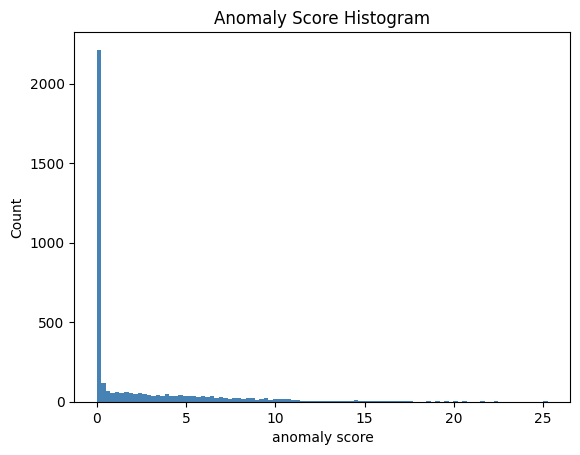

<Figure size 1000x700 with 0 Axes>

In [7]:
def draw_anomaly_score(anomaly_scores):
    plt.hist(anomaly_scores, bins = 100, color='steelblue')
    plt.title(f'Anomaly Score Histogram')
    plt.xlabel('anomaly score')
    # plt.xlim([0,2]) 
    plt.ylabel('Count')
    plt.figure(figsize=(10, 7))
    plt.show()

def process_anomaly_score(test=False):
    if test and not os.path.isdir('./testfig'):
        os.mkdir('./testfig')
    csv_files = read_csv_files(test=test)
    print(sorted(csv_files))
    actual_labels, anomaly_scores, normal_anomaly_scores = get_labels_and_scores_n(csv_files)
    print(len(normal_anomaly_scores))
    draw_anomaly_score(normal_anomaly_scores)
    

process_anomaly_score(test=False)

In [8]:
def calculate_metrics(dic, actual_labels, anomaly_scores):
    optimal_threshold = 5
    predicted_labels = (anomaly_scores > optimal_threshold).astype(int)
    fpr, tpr, thresholds = roc_curve(actual_labels, anomaly_scores)
    auc = roc_auc_score(actual_labels, anomaly_scores)
    f1 = f1_score(actual_labels, predicted_labels)
    optimal_idx = np.argmin(np.abs(thresholds - optimal_threshold))
    return predicted_labels, optimal_threshold, f1, auc, fpr, tpr, optimal_idx

def draw_confusion_matrix(actual_labels, predicted_labels, test=False):
    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
                yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)

    if test:
        plt.title(f'/test', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    else:

        plt.tight_layout()
        plt.show()
    plt.close() 


def draw_roc_curve(fpr, tpr, auc, optimal_idx, optimal_threshold, test=False):
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc="lower right")

    if test:
        plt.title(f'/test', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    else:

        plt.tight_layout()
        plt.show()
    
    plt.close() 

def use_eye(dic, test=False):
    if test and not os.path.isdir('./testfig'):
        os.mkdir('./testfig')
    csv_files = read_csv_files(test=test)
    actual_labels, anomaly_scores = get_labels_and_scores(csv_files)
    results = calculate_metrics(dic, actual_labels, anomaly_scores)
    predicted_labels, optimal_threshold, f1, auc, fpr, tpr, optimal_idx = results

    print(f'Optimal threshold: {optimal_threshold}')
    print(f'F1 Score: {f1}')
    print(f'AUC: {auc}')
    
    draw_confusion_matrix(actual_labels, predicted_labels, test)
    draw_roc_curve(fpr, tpr, auc, optimal_idx, optimal_threshold, test)
    
    return results

dic = {
    '-6_dB' : 0.55,
    '0_dB'  : 0.4,
    '6_dB'  : 0.22
    }


use_eye(dic, test=False)


/home/kseorang/Github/Deep-Learning-Study/STgram-MFN/STgram/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

Optimal threshold: inf
F1 Score: 0.0


/home/kseorang/Github/Deep-Learning-Study/STgram-MFN/STgram/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/kseorang/Github/Deep-Learning-Study/STgram-MFN/STgram/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kseorang/Github/Deep-Learning-Study/STgram-MFN/STgram/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


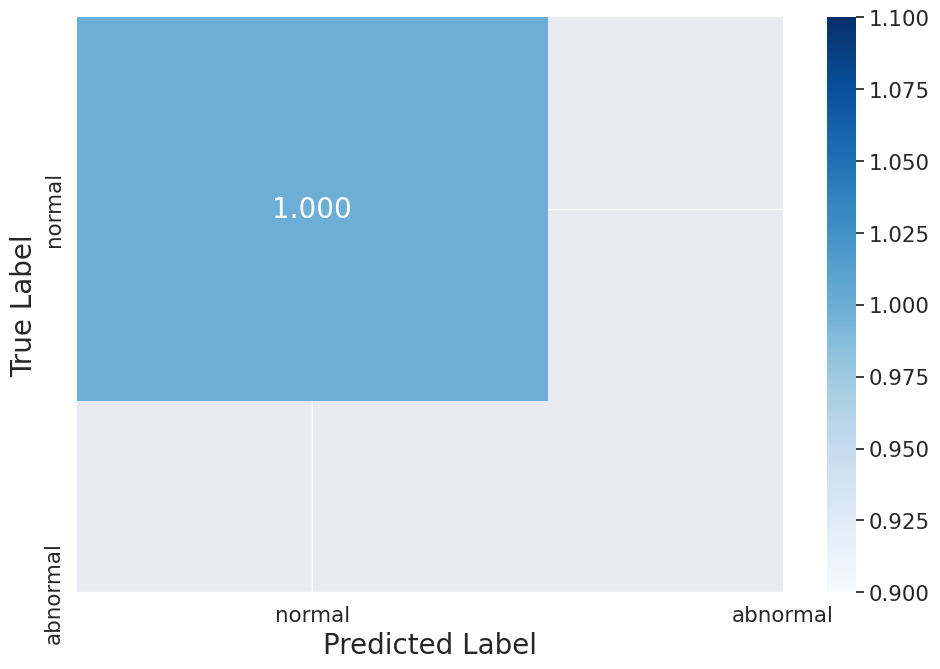

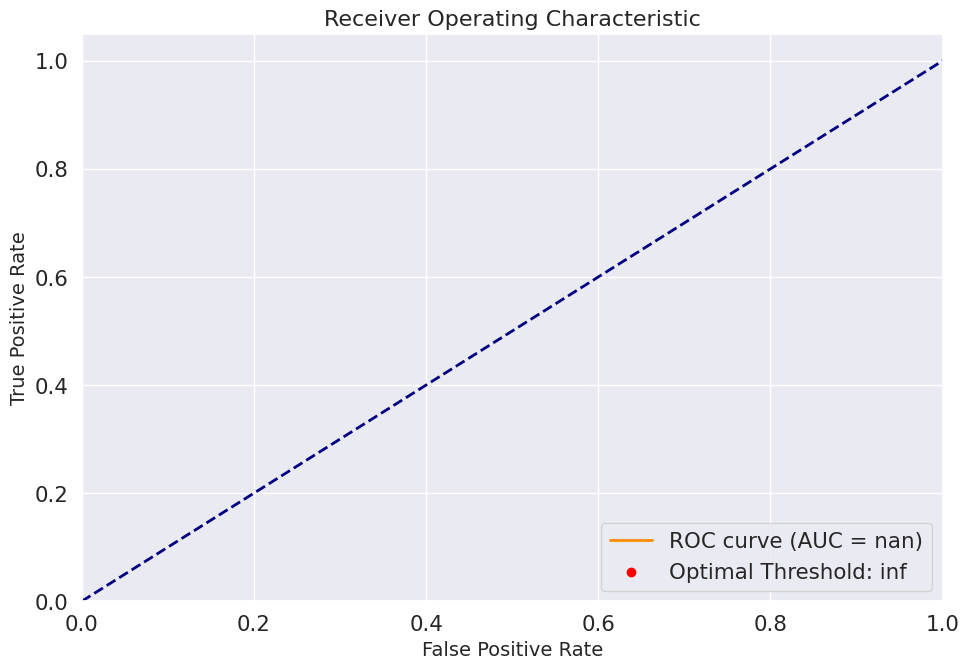

(0       0
 1       0
 2       0
 3       0
 4       0
        ..
 3888    0
 3889    0
 3890    0
 3891    0
 3892    0
 Length: 3893, dtype: int64,
 array([0.00000000e+00, 2.56871307e-04, 6.05959414e-01, 6.06473157e-01,
        6.17518623e-01, 6.18032366e-01, 6.24967891e-01, 6.25481634e-01,
        6.30875931e-01, 6.31389674e-01, 6.33187773e-01, 6.33701516e-01,
        6.36013357e-01, 6.36527100e-01, 6.38068328e-01, 6.38582070e-01,
        6.40380170e-01, 6.40893912e-01, 6.45517596e-01, 6.46288210e-01,
        6.48343180e-01, 6.48856923e-01, 6.49884408e-01, 6.50398151e-01,
        6.53223735e-01, 6.53737478e-01, 6.54508091e-01, 6.55021834e-01,
        6.55278705e-01, 6.55792448e-01, 6.56049319e-01, 6.56563062e-01,
        6.57333676e-01, 6.58618032e-01, 6.59131775e-01, 6.59902389e-01,
        6.60416132e-01, 6.61443617e-01, 6.62471102e-01, 6.63498587e-01,
        6.64269201e-01, 6.65810429e-01, 6.66324172e-01, 6.67094786e-01,
        6.67608528e-01, 6.67865399e-01, 6.68892885e-01, 6.

In [9]:
def calculate_metrics(actual_labels, anomaly_scores):
    fpr, tpr, thresholds = roc_curve(actual_labels, anomaly_scores)
    roc_auc = auc(fpr, tpr)
    J = tpr - fpr
    optimal_idx = np.argmax(J)
    optimal_threshold = thresholds[optimal_idx]
    predicted_labels = (anomaly_scores > optimal_threshold).astype(int)
    f1 = f1_score(actual_labels, predicted_labels)
    return predicted_labels, fpr, tpr, optimal_idx, roc_auc, optimal_threshold, f1

def draw_confusion_matrix(actual_labels, predicted_labels, test=False):
    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
                yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)

    if test:
        plt.tight_layout()
        plt.show()
    else:
        plt.tight_layout()
        plt.show()
    plt.close() 

def draw_roc_curve(fpr, tpr, roc_auc, optimal_idx, optimal_threshold, test=False):
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc="lower right")

    if test:
        plt.tight_layout()
        plt.show()
    else:
        plt.tight_layout()
        plt.show()
    
    plt.close() 

def use_Youden_inede(test=False):
    csv_files = read_csv_files(test=test)
    actual_labels, anomaly_scores = get_labels_and_scores(csv_files)
    results = calculate_metrics(actual_labels, anomaly_scores)
    predicted_labels, fpr, tpr, optimal_idx, roc_auc, optimal_threshold, f1 = results
    
    print(f'Optimal threshold: {optimal_threshold}')
    print(f'F1 Score: {f1}')
    
    draw_confusion_matrix(actual_labels, predicted_labels, test)
    draw_roc_curve(fpr, tpr, roc_auc, optimal_idx, optimal_threshold, test)
    
    return results

use_Youden_inede(test=False)

Z-Score Threshold: 2
F1 Score: 0.0


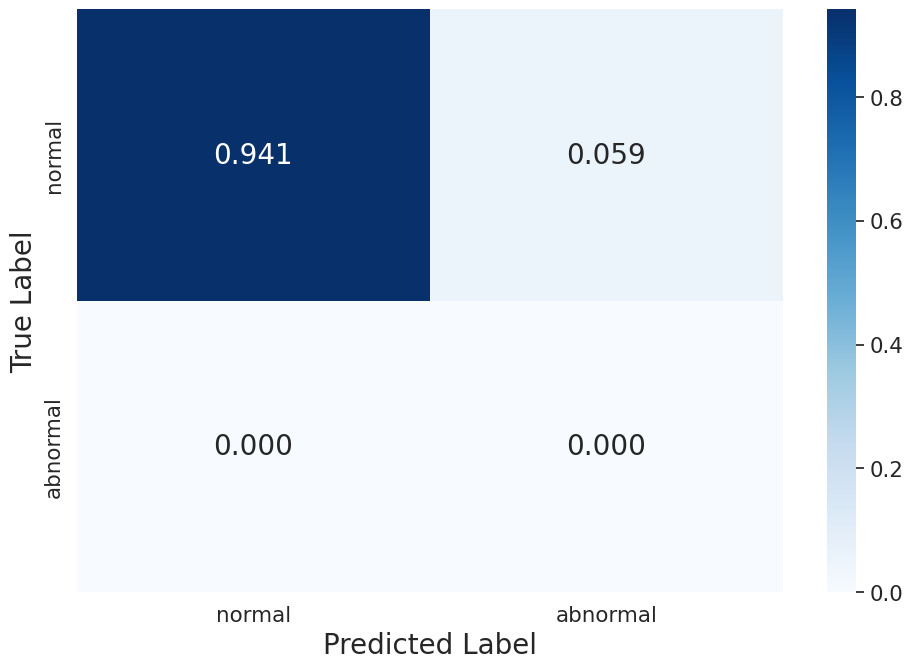

(0       0
 1       0
 2       0
 3       0
 4       0
        ..
 3888    0
 3889    0
 3890    0
 3891    0
 3892    0
 Length: 3893, dtype: int64,
 2,
 np.float64(0.0))

In [10]:
def calculate_metrics_zscore(actual_labels, anomaly_scores, z_threshold=2):
    normal_mean = np.mean(anomaly_scores)
    normal_std = np.std(anomaly_scores)

    # Z-Score 계산
    z_scores = (anomaly_scores - normal_mean) / normal_std
    # Z-Score를 기준으로 이상 감지
    predicted_labels = (z_scores > z_threshold).astype(int)

    # F1 Score 계산
    f1 = f1_score(actual_labels, predicted_labels)

    return predicted_labels, z_threshold, f1

def draw_confusion_matrix(actual_labels, predicted_labels, test=False):
    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
                yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)

    if test:
        plt.tight_layout()
        plt.show()
    else:
        plt.tight_layout()
        plt.show()
    plt.close() 

def use_zscore(test=False):
    csv_files = read_csv_files(test=test)
    actual_labels, anomaly_scores = get_labels_and_scores(csv_files)
    results = calculate_metrics_zscore(actual_labels, anomaly_scores)
    predicted_labels, z_threshold, f1 = results
    
    print(f'Z-Score Threshold: {z_threshold}')
    print(f'F1 Score: {f1}')
    
    draw_confusion_matrix(actual_labels, predicted_labels, test)
    
    return results


use_zscore(test=False)


Z-Score Threshold: 2
F1 Score: 0.0


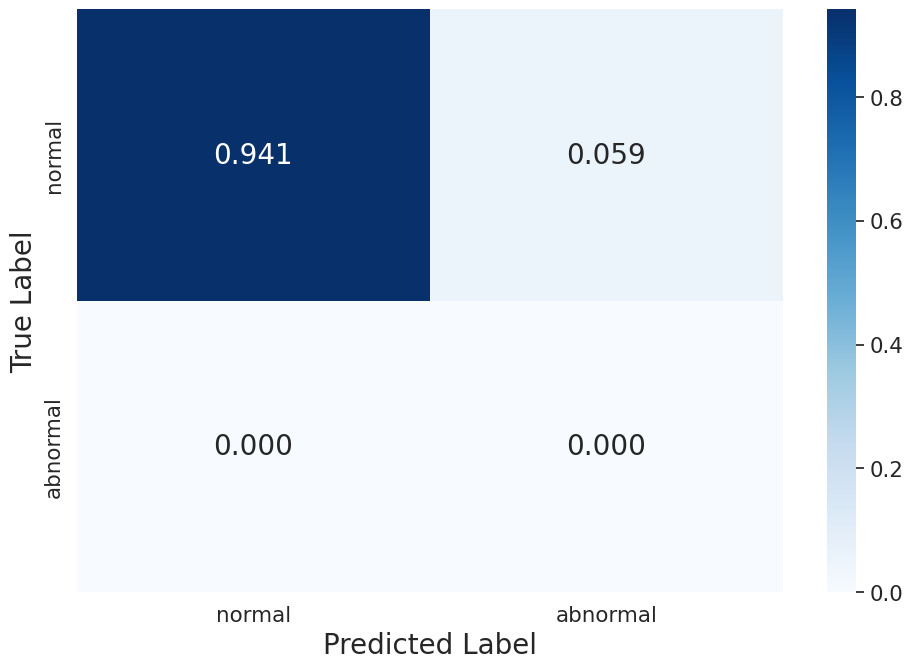

(0       0
 1       0
 2       0
 3       0
 4       0
        ..
 3888    0
 3889    0
 3890    0
 3891    0
 3892    0
 Length: 3893, dtype: int64,
 2,
 np.float64(0.0))

In [11]:
def get_labels_and_scores_n(csv_files):
    actual_labels = []
    anomaly_scores = []
    normal_anomaly_scores = []
    for file in csv_files:
        df = pd.read_csv(file, header=None)
        df.columns = ['filename', 'anomaly_score']
        df['label'] = df['filename'].apply(get_label)
        actual_labels.extend(df['label'].tolist())
        anomaly_scores.extend(df['anomaly_score'].tolist())

        normal_scores = df[df['label'] == 0]['anomaly_score']
        if not normal_scores.empty:
            normal_anomaly_scores.extend(normal_scores.tolist())
    return pd.Series(actual_labels), pd.Series(anomaly_scores), pd.Series(normal_anomaly_scores)

def calculate_metrics_zscore(actual_labels, anomaly_scores, normal_anomaly_scores, z_threshold=2):
    normal_mean = np.mean(normal_anomaly_scores)
    normal_std = np.std(normal_anomaly_scores)

    # Z-Score 계산
    z_scores = (anomaly_scores - normal_mean) / normal_std
    # Z-Score를 기준으로 이상 감지
    predicted_labels = (z_scores > z_threshold).astype(int)

    # F1 Score 계산
    f1 = f1_score(actual_labels, predicted_labels)

    return predicted_labels, z_threshold, f1

def draw_confusion_matrix(actual_labels, predicted_labels, test=False):
    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
                yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)

    if test:
        plt.tight_layout()
        plt.show()
    else:
        plt.tight_layout()
        plt.show()
    plt.close() 

def use_zscore(test=False):
    csv_files = read_csv_files(test=test)
    actual_labels, anomaly_scores, normal_anomaly_scores = get_labels_and_scores_n(csv_files)
    results = calculate_metrics_zscore(actual_labels, anomaly_scores, normal_anomaly_scores)
    predicted_labels, z_threshold, f1 = results
    
    print(f'Z-Score Threshold: {z_threshold}')
    print(f'F1 Score: {f1}')
    
    draw_confusion_matrix(actual_labels, predicted_labels, test)
    
    return results

use_zscore(test=False)


In [12]:
def calculate_metrics_modified_zscore(actual_labels, anomaly_scores, z_threshold=3.5):
    median = np.median(anomaly_scores)
    median_absolute_deviation = np.median(np.abs(anomaly_scores-median))

    # Z-Score 계산
    modified_z_scores = 0.6745*(anomaly_scores - median) / median_absolute_deviation
    # Z-Score를 기준으로 이상 감지
    predicted_labels = (np.abs(modified_z_scores) > z_threshold).astype('int')

    # F1 Score 계산
    f1 = f1_score(actual_labels, predicted_labels)

    return predicted_labels, z_threshold, f1
    

def draw_confusion_matrix(actual_labels, predicted_labels, snr, test=False):
    cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
                yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)

    if test:
        plt.title(f'{snr}/test', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    else:
        plt.title(f'{snr}', pad=20, fontsize=20)
        plt.tight_layout()
        plt.show()
    plt.close() 

def use_modified_zscore(snr, test=False):
    csv_files = read_csv_files(snr, test=test)
    actual_labels, anomaly_scores = get_labels_and_scores(csv_files)
    results = calculate_metrics_modified_zscore(actual_labels, anomaly_scores)
    predicted_labels, z_threshold, f1 = results
    
    print(f'SNR: {snr}')
    print(f'Z-Score Threshold: {z_threshold}')
    print(f'F1 Score: {f1}')
    
    draw_confusion_matrix(actual_labels, predicted_labels, snr, test)
    
    return results

use_modified_zscore(snr, test=True)


NameError: name 'snr' is not defined

In [ ]:
# def calculate_metrics_IQR(actual_labels, anomaly_scores, z_threshold=3.5):
#     quartile_1, quartile_3 = np.percentile(anomaly_scores, [25, 75])
#     iqr = quartile_3 - quartile_1
#     lower_bound = quartile_1 - (iqr * 1.5)
#     upper_bound = quartile_3 + (iqr * 1.5)


#     predicted_labels = ((anomaly_scores > upper_bound) | (anomaly_scores < lower_bound)).astype('int')

#     # F1 Score 계산
#     f1 = f1_score(actual_labels, predicted_labels)

#     return predicted_labels, z_threshold, f1
    

# def draw_confusion_matrix(actual_labels, predicted_labels, snr, test=False):
#     cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
#     plt.figure(figsize=(10, 7))
#     sns.set(font_scale=1.4)
#     sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
#                 yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
#     plt.xlabel('Predicted Label', fontsize=20)
#     plt.ylabel('True Label', fontsize=20)

#     if test:
#         plt.title(f'{snr}/test', pad=20, fontsize=20)
#         plt.tight_layout()
#         plt.show()
#     else:
#         plt.title(f'{snr}', pad=20, fontsize=20)
#         plt.tight_layout()
#         plt.show()
#     plt.close() 

# def use_IQR(snr, test=False):
#     csv_files = read_csv_files(snr, test=test)
#     actual_labels, anomaly_scores = get_labels_and_scores(csv_files)
#     results = calculate_metrics_IQR(actual_labels, anomaly_scores)
#     predicted_labels, z_threshold, f1 = results
    
#     print(f'SNR: {snr}')
#     print(f'Z-Score Threshold: {z_threshold}')
#     print(f'F1 Score: {f1}')
    
#     draw_confusion_matrix(actual_labels, predicted_labels, snr, test)
    
#     return results

# for snr in snr_list:
#     use_IQR(snr, test=True)


In [ ]:
# def calculate_metrics_IQR_n(actual_labels, anomaly_scores, normal_anomaly_scores):
#     quartile_1, quartile_3 = np.percentile(normal_anomaly_scores, [25, 75])
#     iqr = quartile_3 - quartile_1
#     lower_bound = quartile_1 - (iqr * 1.5)
#     upper_bound = quartile_3 + (iqr * 1.5)


#     predicted_labels = ((anomaly_scores > upper_bound) | (anomaly_scores < lower_bound)).astype('int')

#     # F1 Score 계산
#     f1 = f1_score(actual_labels, predicted_labels)

#     return predicted_labels, f1
    

# def draw_confusion_matrix(actual_labels, predicted_labels, snr, test=False):
#     cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
#     plt.figure(figsize=(10, 7))
#     sns.set(font_scale=1.4)
#     sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
#                 yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
#     plt.xlabel('Predicted Label', fontsize=20)
#     plt.ylabel('True Label', fontsize=20)

#     if test:
#         plt.title(f'{snr}/test', pad=20, fontsize=20)
#         plt.tight_layout()
#         plt.show()
#     else:
#         plt.title(f'{snr}', pad=20, fontsize=20)
#         plt.tight_layout()
#         plt.show()
#     plt.close() 

# def use_IQR(snr, test=False):
#     csv_files = read_csv_files(snr, test=test)
#     actual_labels, anomaly_scores, normal_anomaly_scores = get_labels_and_scores_n(csv_files)
#     results = calculate_metrics_IQR_n(actual_labels, anomaly_scores, normal_anomaly_scores)
#     predicted_labels, f1 = results
    
#     print(f'SNR: {snr}')
#     print(f'F1 Score: {f1}')
    
#     draw_confusion_matrix(actual_labels, predicted_labels, snr, test)
    
#     return results

# for snr in snr_list:
#     use_IQR(snr, test=False)


In [ ]:
# def max_f1score(actual_labels, anomaly_scores, snr):
#     precision, recall, thresholds = precision_recall_curve(actual_labels, anomaly_scores)
#     f1_score =  2 * (precision * recall) / (precision + recall)

#     optimal_idx = np.argmax(f1_score)
#     optimal_threshold = thresholds[optimal_idx]
#     predicted_labels = (anomaly_scores > optimal_threshold).astype(int)

#     # Precision-Recall Curve 시각화
#     plt.figure(figsize=(10, 7))
#     plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
#     plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', label=f'Optimal Threshold: {optimal_threshold}')
#     plt.xlabel('Recall', fontsize=14)
#     plt.ylabel('Precision', fontsize=14)
#     plt.title(f'{snr} Precision-Recall Curve', fontsize=16)
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     return optimal_threshold, predicted_labels, f1_score[optimal_idx]

# def draw_confusion_matrix(actual_labels, predicted_labels, snr, test=False):
#     cm = confusion_matrix(actual_labels, predicted_labels, normalize='true')
#     plt.figure(figsize=(10, 7))
#     sns.set(font_scale=1.4)
#     sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['normal', 'abnormal'],
#                 yticklabels=['normal', 'abnormal'], annot_kws={"size":20})
#     plt.xlabel('Predicted Label', fontsize=20)
#     plt.ylabel('True Label', fontsize=20)

#     if test:
#         plt.title(f'{snr}/test', pad=20, fontsize=20)
#         plt.tight_layout()
#         plt.savefig(f'./testfig/confusion_matrix_{snr}')
#     else:
#         plt.title(f'{snr}', pad=20, fontsize=20)
#         plt.tight_layout()
#         plt.savefig(f'./confusion_matrix_{snr}')
#     plt.show() 

# def use_max_f1(snr, test=False):
#     csv_files = read_csv_files(snr, test=test)
#     actual_labels, anomaly_scores = get_labels_and_scores(csv_files)
#     optimal_threshold, predicted_labels, f1 = max_f1score(actual_labels, anomaly_scores, snr)
    
#     draw_confusion_matrix(actual_labels, predicted_labels, snr, test)
#     AUPRC = average_precision_score(actual_labels, anomaly_scores)

#     print(f'SNR: {snr}')
#     print(f'Optimal threshold: {optimal_threshold}')
#     print(f'F1 Score: {f1}')
#     print(f'Average Precision Score: {AUPRC}')

# for snr in snr_list:
#     use_max_f1(snr, test=False)
